In [1]:
setwd('..')

In [2]:
# getwd()

In [4]:
library(dplyr)

In [5]:
years = 2016:2023
conf_name = '003'

## Read data

In [6]:
results_orig = read.csv(sprintf('results/%s/ci_summary_avg.csv', conf_name))
dim(results_orig)
head(results_orig)

[1] 12612    20

,Actual,Pred,Pred.lower,Pred.upper,Pred.sd,AbsEffect,AbsEffect.lower,AbsEffect.upper,AbsEffect.sd,RelEffect,RelEffect.lower,RelEffect.upper,RelEffect.sd,alpha,p,obs_id,event_date,n_events,max_score,sum_score
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<dbl>,<dbl>
1,1.1065062,1.0091901,0.4542015,1.622342,0.3003905,0.09731613,-0.5158360,0.6523048,0.3003905,0.22735923,-0.3179574,1.4362214,0.5901228,0.05,0.36036036,AALI,2016-02-05,1,0.6107671,0.6107671
2,1.2256995,1.0294899,0.2563479,1.749458,0.3915923,0.19620963,-0.5237581,0.9693517,0.3915923,0.68052674,-0.3162937,3.4791918,8.3351864,0.05,0.30688935,AALI,2016-02-29,1,0.5373070,0.5373070
3,0.9125030,1.0295840,0.2511440,1.725064,0.3718314,-0.11708100,-0.8125607,0.6613590,0.3718314,-0.09613304,-0.4840724,1.7688164,3.2036239,0.05,0.36430063,AALI,2016-03-14,1,0.6783051,0.6783051
4,0.7238977,1.0005072,0.3427610,1.667591,0.3496471,-0.27660957,-0.9436931,0.3811367,0.3496471,4.82800826,-0.5686528,1.0346843,154.1028638,0.05,0.23377961,AALI,2016-04-25,1,0.6064426,0.6064426
5,1.8020138,0.9976611,-0.4154579,2.391863,0.7078230,0.80435262,-0.5898493,2.2174717,0.7078230,-0.22265425,-10.2584509,18.4554022,58.1956480,0.05,0.13913914,AALI,2016-08-16,1,0.5889188,0.5889188
6,0.2665706,0.9920697,-0.1886735,2.138159,0.5821746,-0.72549904,-1.8715880,0.4552442,0.5821746,-0.69454942,-1.9979285,0.9753346,1.9593139,0.05,0.09989701,AALI,2016-09-07,1,0.5048047,0.5048047


In [7]:
table(lubridate::year(results_orig$event_date))


2016 2017 2018 2019 2020 2021 2022 2023 
 541 1342 1951  833 1080 1390 3157 2318 

In [8]:
length(unique(results_orig$obs_id))

[1] 626

In [9]:
head(sort(table(results_orig$obs_id), decreasing=TRUE), 30)


BBRI BBCA BMRI BBNI TLKM ADRO PTBA ANTM ASII AALI UNVR ICBP LSIP INDF INCO ITMG 
 441  382  380  361  287  274  269  263  247  242  242  241  227  220  192  186 
PGAS MEDC BBTN KLBF BSDE AKRA WIKA SMGR UNTR JSMR MYOR INDY CTRA PTPP 
 180  150  148  139  134  132  117  116  116  109  109  107  104  103 

## Process data

In [10]:
results = results_orig %>%
    mutate(event_year=lubridate::year(event_date), Effect=Actual - Pred) %>%
    group_by(obs_id, event_year) %>%
    summarise(n=n(), mean_p=mean(p), sd_p=sd(p), mean_eff=mean(Effect), sd_eff=sd(Effect)) %>%
    group_by(obs_id) %>% filter(n() > 1) %>%    # discard firms which only appeared in 1 year
    arrange(obs_id, event_year) %>%
    plm::pdata.frame(index=c('obs_id', 'event_year'))
dim(results)
head(results)

`summarise()` has grouped output by 'obs_id'. You can override using the `.groups` argument.


[1] 1759    7

,obs_id,event_year,n,mean_p,sd_p,mean_eff,sd_eff
,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
AALI-2016,AALI,2016,8,0.2152960,0.1167251,-0.11154604,0.4773019
AALI-2017,AALI,2017,25,0.1880452,0.1260938,-0.13516747,0.3494676
AALI-2018,AALI,2018,35,0.1747006,0.1597063,0.03657328,1.0692680
AALI-2019,AALI,2019,20,0.2172153,0.1542257,0.01687586,0.7285473
AALI-2020,AALI,2020,32,0.1704617,0.1267458,0.11039819,0.3976536
AALI-2021,AALI,2021,41,0.1676779,0.1457199,0.17429267,1.1208758


In [11]:
table(results$event_year)


2016 2017 2018 2019 2020 2021 2022 2023 
 136  223  245  181  197  223  293  261 

In [12]:
length(unique(results$obs_id))

[1] 404

In [13]:
table(table(results$obs_id))


  2   3   4   5   6   7   8 
123  68  57  27  25  36  68 

In [14]:
plm::punbalancedness(results)

gamma        nu 
0.7629038 0.7889787

## Test hypothesis

In [15]:
summary(results$mean_p)

total sum of squares: 20.75515 
         id        time 
0.307971201 0.006414354 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0010  0.1226  0.1902  0.1943  0.2576  0.4985 

In [16]:
mean(results$mean_p <= 0.05)

[1] 0.1017624

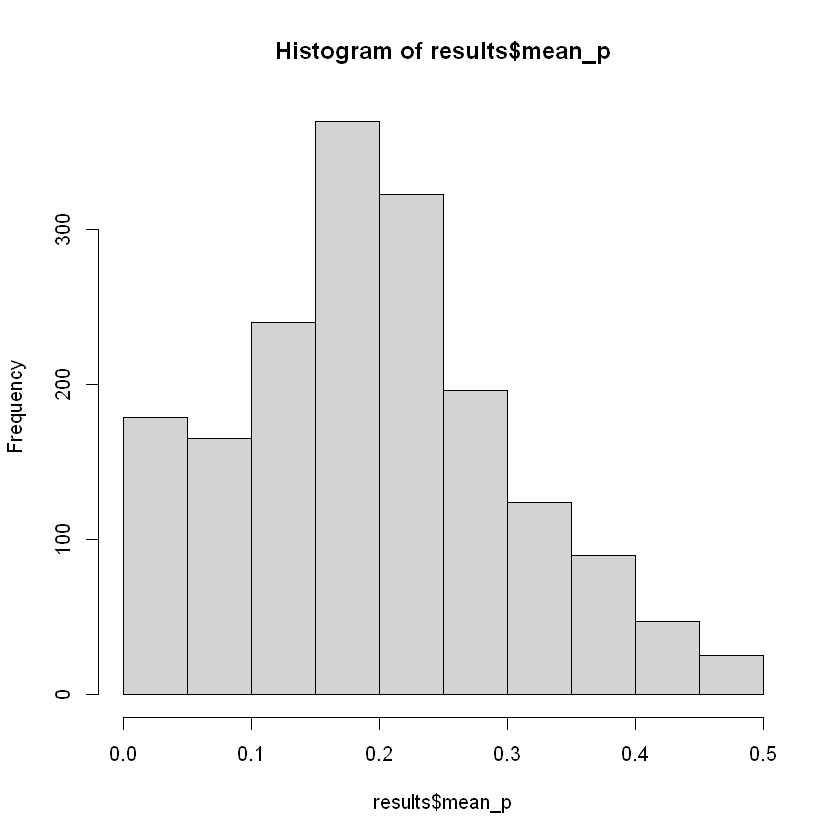

In [17]:
hist(results$mean_p)

In [18]:
summary(results$mean_eff)

total sum of squares: 1709874 
        id       time 
0.47631593 0.01139522 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 -1.2362  -0.3462  -0.0100   2.4763   0.3911 657.6537 

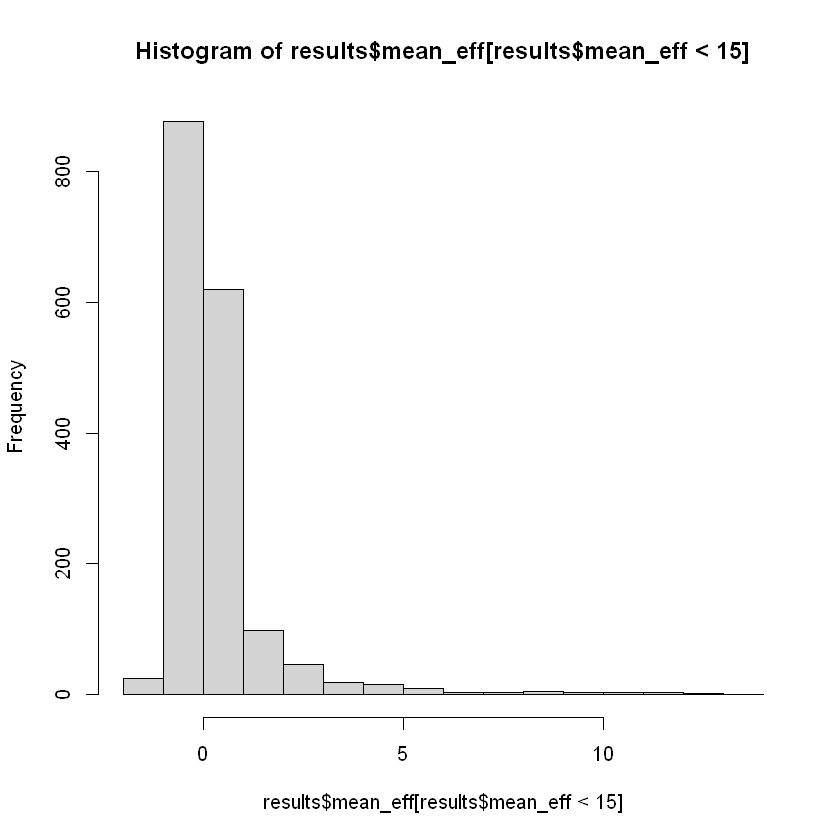

In [19]:
hist(results$mean_eff[results$mean_eff < 15])